In [116]:
MAX_N = 6  # Maximum number of parallel processes

In [117]:
def process_std_out(out: str):
    arr = out.split("\n")

    loaders = []
    centroids = []
    allreduce = []
    processing = []

    centroid_zero = 0

    for line in arr:
        data = line.split(" ")

        if len(data) != 3:
            continue

        type = data[0]
        rank = data[1]
        value = data[2]

        if type == "loader":
            loaders.append((rank, value))

        if type == "centroid_initialization":
            centroids.append((rank, value))
            if int(rank) == 0:
                centroid_zero = float(value)

        if type == "all_reduce":
            allreduce.append((rank, value))

        if type == "processing":
            processing.append((rank, value))

    # get mean of loaders
    data_loading_time = sum([float(x[1]) for x in loaders]) / len(loaders)
    # print("data loading time: ", data_loading_time // 1000)

    centroids_diff = []
    for rank, value in centroids:
        centroids_diff.append(float(value) - float(centroid_zero))

    centroid_time = sum(centroids_diff) / len(centroids_diff)
    # print("centroid time: ", centroid_time)

    allreduce_time = sum([float(x[1]) for x in allreduce]) / len(allreduce)
    # print("allreduce time: ", allreduce_time)

    # print("communication time", (centroid_time + allreduce_time) // 1000)

    processing_time = sum([float(x[1]) for x in processing]) / len(processing)
    # print("processing time: ", processing_time // 1000)

    return data_loading_time, centroid_time + allreduce_time, processing_time

In [124]:
import subprocess

data = []
rows = [1000, 2000, 5000, 10000, 20000, 50000, 100000]

# identify how many parallel mpi processes to can run
for i in range(1, MAX_N + 1):
    for y in rows:
        out = subprocess.run(
            ["mpirun", "-n", str(i), "python", "single.py", str(y)],
            stdout=subprocess.PIPE,
        ).stdout.decode("utf-8")

        loading, communication, processing = process_std_out(out)

        data.append((i, y, loading, communication, processing))

In [125]:
import pandas as pd

df = pd.DataFrame(
    data, columns=["no of processors", "rows", "loading", "communication", "processing"]
)
df.head()

,no of processors,rows,loading,communication,processing
0,1,1000,2617495.0,55529.866667,6734586.0
1,1,2000,3183893.0,41739.866667,7000886.0
2,1,5000,4829790.0,51439.933333,12582974.0
3,1,10000,7864484.0,49833.133333,19860559.0
4,1,20000,14020170.0,53376.633333,36492825.0


/home/chxru/p/kmeans-mpi/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/chxru/p/kmeans-mpi/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/chxru/p/kmeans-mpi/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/chxru/p/kmeans-mpi/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

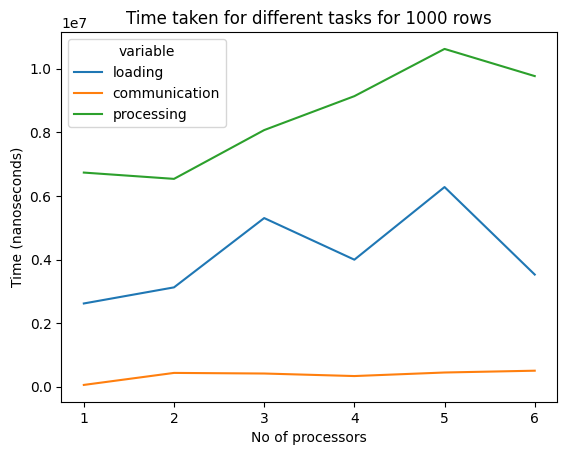

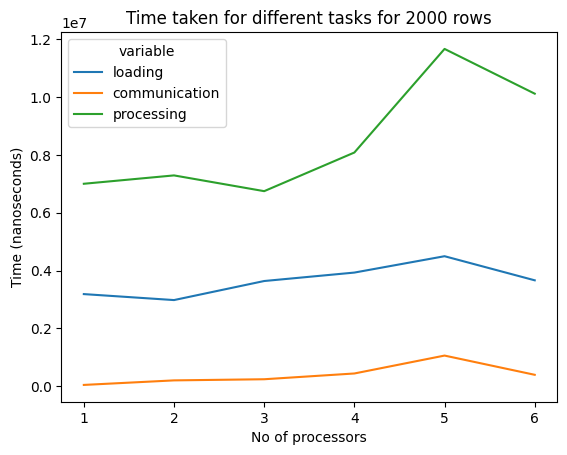

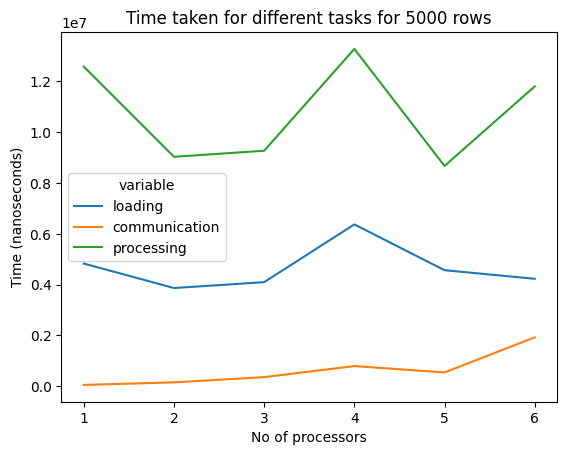

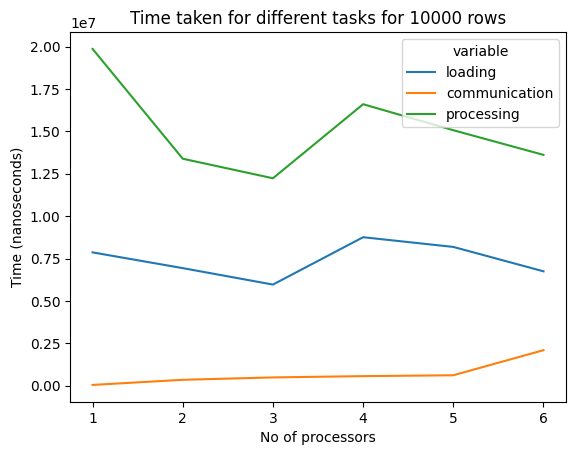

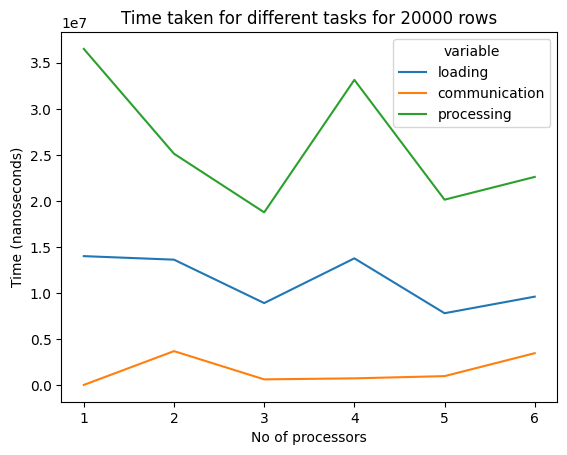

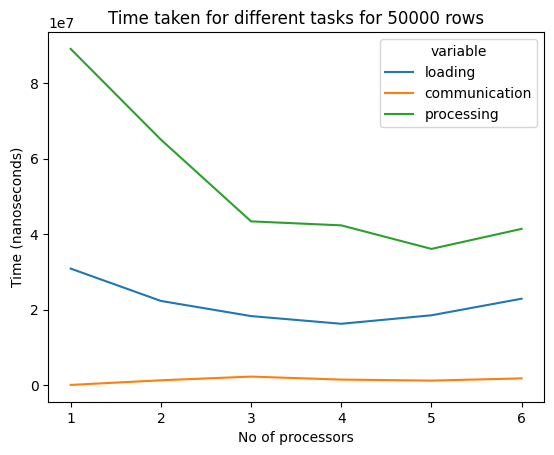

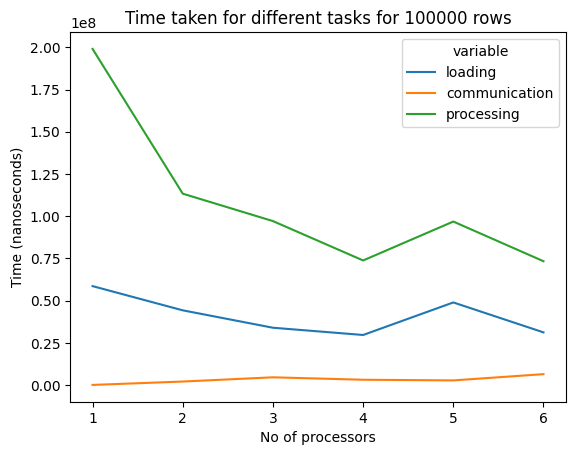

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns


def show_graph(row: int):
    data_wide = pd.melt(
        df[df["rows"] == row],
        id_vars=["no of processors"],
        value_vars=["loading", "communication", "processing"],
    )

    fig = sns.lineplot(data=data_wide, x="no of processors", y="value", hue="variable")
    fig.set_title(f"Time taken for different tasks for {row} rows")
    fig.set_ylabel("Time (nanoseconds)")
    fig.set_xlabel("No of processors")

    # fig.figure.savefig(f"metrics_{row}.png")


for i, row in enumerate(rows):
    plt.figure(i)
    show_graph(row)